# Barter Deals

In [16]:
import os
from dotenv import load_dotenv
import numpy as np

import pandas as pd
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv("../private_data/.env")

host = os.getenv("HOST")
db = os.getenv("DB")
port = os.getenv("PORT")
role = os.getenv("ROLE")
pw = os.getenv("PASSWORD")
engine = create_engine(f"postgresql+psycopg2://{role}:{pw}@{host}:{port}/{db}")

# Notes

Columns
- planned_applications == upcoming_applications
- total_applications != completed + pending + cancelled
    - Another application status missing?
- Status is current status:
    - A deal in draft could have been active previously
- Deals deleted at: website says theyre kept for 30 days, but theyre saved in the database
- created_at: unreliable, probably took default value of 2025-05-01 after some update. Use deal_created_at instead
- Deals where diff()
    - Could be interesting, if many applicants
    - Might be noisy
    - Few applicants might mean unpopular deal
- Relationship between creator rating and acceptance rate?
Data quality
    - Same deal can be put live multiple times
        - Live_since = last time deal has been put live
        - Applications_log: some applications might be from before live_since
        - Might be fixable with deals_log

# Load data

In [17]:
host

'rds-proxy.staging.getbarter.tech'

In [18]:
query = 'SELECT * FROM public.deals;'
df_deals = pd.read_sql(query, engine)
df_deals_cols_of_interest = [
    'id', 'partner_id', 'creators_requirement', 'deal_value', 'social_requirement_type_id']

query = 'SELECT * FROM public.deals_computed;'
df_deals_comp = pd.read_sql(query, engine)

query = 'SELECT * FROM public.partners;'
df_partners = pd.read_sql(query, engine)

In [19]:
df_partners

,legacy_id,user_id,name,customer_id,status,created_at,updated_at,deleted_at,tags,id,company_name,company_size,website,worked_with_creators,references,reference_reason
0,2335,50016,Otto Visser,cus_SwEZWpqzVk41hB,Active,2025-08-26 12:37:52.448398+00:00,2025-08-28 22:25:18.069616+00:00,None,[partner.new],0198f2c3-7060-0065-4e76-d6471ed371e1,None,None,None,None,None,None
1,2334,50014,Lieke Terlouw,cus_SwEAwUFtMkGoLI,Active,2025-08-26 12:11:43.469173+00:00,2025-08-28 22:25:18.310572+00:00,None,[partner.new],0198f2c3-7030-0065-a7df-358e39b45292,None,None,None,None,None,None
2,2333,50013,Juliette Brouwer,cus_SwDmJrZfUq95V8,Active,2025-08-26 11:47:43.704440+00:00,2025-08-28 22:25:18.550086+00:00,None,[partner.new],0198f2c3-7000-0065-4501-740f8ae53037,None,None,None,None,None,None
3,2332,50012,Bobbi Verbeek,cus_SwDegU4P3GIHP0,Active,2025-08-26 11:39:31.791976+00:00,2025-08-28 22:25:18.789790+00:00,None,[partner.new],0198f2c3-6fd0-0065-9beb-1a81494cafc3,None,None,None,None,None,None
4,2331,49999,Jolijn Bakker,cus_SwCFE8DH4I4LJs,Active,2025-08-26 10:12:31.780766+00:00,2025-08-28 22:25:19.034548+00:00,None,[partner.new],0198f2c3-6f9f-0065-553a-bb0fe0eacf77,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,5,17,Elise van Dijk,cus_Oaqt1awX3uphsd,Active,2023-09-07 10:12:21.076055+00:00,2025-08-28 22:33:54.851608+00:00,None,None,0198f2c3-1666-0065-a3e3-555a4980a1bc,None,None,None,None,None,None
3302,4,12,Lizzy Koning,,Active,2023-09-07 09:09:34.709951+00:00,2025-08-28 22:33:55.091002+00:00,None,None,0198f2c3-19c3-0065-85d2-92e5aab4d04b,None,None,None,None,None,None
3303,3,11,Flip Cornelissen,,Active,2023-09-07 08:53:12.691045+00:00,2025-08-28 22:33:55.330645+00:00,None,None,0198f2c3-1247-0065-1b35-9399bdc56169,None,None,None,None,None,None
3304,2,4,Benja van de Brink,,Active,2023-09-07 07:06:14.851036+00:00,2025-08-28 22:33:55.571756+00:00,None,None,0198f2c3-11e8-0065-8705-a0b02930f54c,None,None,None,None,None,None


In [20]:
df = df_deals_comp.copy()


df["first_application_at"] = pd.to_datetime(
    df["first_application_at"], errors='coerce')
df["last_application_at"] = pd.to_datetime(
    df["last_application_at"], errors='coerce')

df["deal_id_str"] = df["deal_id"].astype(str)


df = pd.merge(df_deals[df_deals_cols_of_interest],
              df,
              left_on='id', right_on='deal_id', how='outer')

In [21]:
df.loc[:, 'first_content_type'] = df.content_types.apply(
    lambda x: x[0]['name'] if type(x) is list else "None")

# EDA

- first_application_at and last_application_at are interesting, but also missing in 18% of the cases. 
    - first_application_at == last_application_at == (applications_count == 0)
    - Assuming that deals are not often intermittently offline for long, we can use $last \ application - first \ application$ as a measure for how many days it was online. Problem: it might have been inactive intermittently, and I dont know for how long. 
- live_since and created_at equal in 50% of the cases. live_since > created_at in 30% of the cases. 

General inspection: what are deals?

In [22]:
df.loc[:, ['title', 'description', 'applicants_applications_count']]

,title,description,applicants_applications_count
0,Heerlijke steak bij Coco's Outback in Amsterdam,Je bent welkom om nog een persoon mee te nemen...,67.0
1,Wedding card prank edition | Pranktastic.com,Pranktastic is on the lookout for enthusiastic...,4.0
2,Outdoor chalkboard and markers to celebrate go...,Celebrate good times with our rectangle chalkb...,7.0
3,Moeders gezocht: Help kids hun scherm afsluite...,"""Er is een hele wereld buiten het scherm – vol...",4.0
4,Rando Music VST Sampler/Plugin Promotion,"For our flagship product, Rando, we are lookin...",5.0
...,...,...,...
5297,New Customer Deal,A fantastic opportunity for content creators t...,0.0
5298,Happy Hour Deal,We are looking for creative content creators t...,1.0
5299,Holiday Special,A fantastic opportunity for content creators t...,0.0
5300,erggregr tyr eyerty erty,rtehertherth,0.0


In [26]:
df[df.applicants_applications_count == 0]

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,last30_days_upcoming_applications_count,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,first_content_type
16,019689e1-e8ec-00c8-afda-5b22efc736c8,1104,- 1 unboxing video op Instagram en TikTok\n- 1...,0.0,3.0,2025-05-01 05:36:14.470787,2025-05-27 06:45:34.926328,NaT,17.0,019689e1-e8ec-00c8-afda-5b22efc736c8,...,0.0,0.0,0.0,False,[NLD],5000.0,2025-02-21 12:30:53.965962,NaT,019689e1-e8ec-00c8-afda-5b22efc736c8,Luxury
24,019689e1-eda6-00c8-db19-2eced64d8bad,1127,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.292943,2025-11-05 06:10:30.354997,NaT,25.0,019689e1-eda6-00c8-db19-2eced64d8bad,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 07:53:36.034463,NaT,019689e1-eda6-00c8-db19-2eced64d8bad,Cooking
27,019689e1-efca-00c8-9414-75bb2889b288,1127,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.558393,2025-11-05 06:10:32.852570,NaT,28.0,019689e1-efca-00c8-9414-75bb2889b288,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 08:11:38.874922,NaT,019689e1-efca-00c8-9414-75bb2889b288,Cooking
31,019689e1-f199-00c8-42f5-32b723f9d221,1127,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.949964,2025-11-05 06:10:35.555071,NaT,32.0,019689e1-f199-00c8-42f5-32b723f9d221,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 08:27:21.868747,NaT,019689e1-f199-00c8-42f5-32b723f9d221,Experiences
33,019689e1-f307-00c8-9458-5748fdac1b39,1221,"Look at the book, the stories, maps and photo'...",0.0,2.0,2025-05-01 05:36:16.087402,2025-05-27 06:45:36.380945,NaT,34.0,019689e1-f307-00c8-9458-5748fdac1b39,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 10:34:33.573469,NaT,019689e1-f307-00c8-9458-5748fdac1b39,Experiences
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5296,019a1655-d02e-00c8-d53b-091c48dc8a13,3471,Produce high-quality Instagram content includi...,629.0,34.0,2025-10-24 21:08:20.222315,2025-11-05 06:47:10.356400,NaT,5212.0,019a1655-d02e-00c8-d53b-091c48dc8a13,...,0.0,0.0,0.0,False,[ITA],0.0,NaT,NaT,019a1655-d02e-00c8-d53b-091c48dc8a13,Beauty
5297,019a262e-9238-00c8-cc3c-9613505fd1c0,3474,Develop creative TikTok content (3-4 videos) a...,838.0,34.0,2025-10-27 20:28:05.562148,2025-11-05 06:47:10.554872,NaT,5213.0,019a262e-9238-00c8-cc3c-9613505fd1c0,...,0.0,0.0,0.0,False,[],0.0,NaT,NaT,019a262e-9238-00c8-cc3c-9613505fd1c0,Beauty
5299,019a8200-3c35-00c8-edf3-fbcfed9a8cfa,3490,Create YouTube videos (1-2) and Instagram cont...,1650.0,34.0,2025-11-14 10:54:05.780830,2025-11-14 10:54:05.780830,NaT,5215.0,019a8200-3c35-00c8-edf3-fbcfed9a8cfa,...,0.0,0.0,0.0,False,[DEU],0.0,NaT,NaT,019a8200-3c35-00c8-edf3-fbcfed9a8cfa,Beauty
5300,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,701,erhreherhrtg reertg rertgh,NaN,1.0,2025-11-17 12:22:45.993564,2025-11-24 15:07:19.655533,NaT,5216.0,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,...,0.0,0.0,0.0,True,[],1500.0,2025-11-24 15:07:17.604166,NaT,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,None


In [31]:
# Create a mask for rows where 'test' appears in EITHER column
mask = df['title'].str.contains('test') | df['description'].str.contains('test')

# Invert the mask with '~' to keep rows that DO NOT contain the string
# df[(~mask) & (df.applicants_applications_count == 0)]

zero_apps = df[(~mask) & (df.applicants_applications_count == 0)]
zero_apps

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,last30_days_upcoming_applications_count,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,first_content_type
16,019689e1-e8ec-00c8-afda-5b22efc736c8,1104,- 1 unboxing video op Instagram en TikTok\n- 1...,0.0,3.0,2025-05-01 05:36:14.470787,2025-05-27 06:45:34.926328,NaT,17.0,019689e1-e8ec-00c8-afda-5b22efc736c8,...,0.0,0.0,0.0,False,[NLD],5000.0,2025-02-21 12:30:53.965962,NaT,019689e1-e8ec-00c8-afda-5b22efc736c8,Luxury
31,019689e1-f199-00c8-42f5-32b723f9d221,1127,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.949964,2025-11-05 06:10:35.555071,NaT,32.0,019689e1-f199-00c8-42f5-32b723f9d221,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 08:27:21.868747,NaT,019689e1-f199-00c8-42f5-32b723f9d221,Experiences
33,019689e1-f307-00c8-9458-5748fdac1b39,1221,"Look at the book, the stories, maps and photo'...",0.0,2.0,2025-05-01 05:36:16.087402,2025-05-27 06:45:36.380945,NaT,34.0,019689e1-f307-00c8-9458-5748fdac1b39,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 10:34:33.573469,NaT,019689e1-f307-00c8-9458-5748fdac1b39,Experiences
37,019689e1-f4de-00c8-d3bc-b196a08582f5,1053,We expect two videos from this event:\n\nInsta...,0.0,3.0,2025-05-01 05:36:16.282776,2025-11-05 06:10:39.455005,NaT,38.0,019689e1-f4de-00c8-d3bc-b196a08582f5,...,0.0,0.0,0.0,False,[NLD],5000.0,2025-02-22 10:37:59.529628,2025-03-07 23:59:59,019689e1-f4de-00c8-d3bc-b196a08582f5,Music
41,019689e1-f6c7-00c8-7303-783e11ad292f,1014,- De eerste post moet binnen 2 weken na ontvan...,0.0,2.0,2025-05-01 05:36:16.597324,2025-05-06 20:39:32.865374,2025-05-26 11:41:16.293000+00:00,42.0,019689e1-f6c7-00c8-7303-783e11ad292f,...,0.0,0.0,0.0,False,[NLD],2500.0,NaT,NaT,019689e1-f6c7-00c8-7303-783e11ad292f,UGC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5296,019a1655-d02e-00c8-d53b-091c48dc8a13,3471,Produce high-quality Instagram content includi...,629.0,34.0,2025-10-24 21:08:20.222315,2025-11-05 06:47:10.356400,NaT,5212.0,019a1655-d02e-00c8-d53b-091c48dc8a13,...,0.0,0.0,0.0,False,[ITA],0.0,NaT,NaT,019a1655-d02e-00c8-d53b-091c48dc8a13,Beauty
5297,019a262e-9238-00c8-cc3c-9613505fd1c0,3474,Develop creative TikTok content (3-4 videos) a...,838.0,34.0,2025-10-27 20:28:05.562148,2025-11-05 06:47:10.554872,NaT,5213.0,019a262e-9238-00c8-cc3c-9613505fd1c0,...,0.0,0.0,0.0,False,[],0.0,NaT,NaT,019a262e-9238-00c8-cc3c-9613505fd1c0,Beauty
5299,019a8200-3c35-00c8-edf3-fbcfed9a8cfa,3490,Create YouTube videos (1-2) and Instagram cont...,1650.0,34.0,2025-11-14 10:54:05.780830,2025-11-14 10:54:05.780830,NaT,5215.0,019a8200-3c35-00c8-edf3-fbcfed9a8cfa,...,0.0,0.0,0.0,False,[DEU],0.0,NaT,NaT,019a8200-3c35-00c8-edf3-fbcfed9a8cfa,Beauty
5300,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,701,erhreherhrtg reertg rertgh,NaN,1.0,2025-11-17 12:22:45.993564,2025-11-24 15:07:19.655533,NaT,5216.0,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,...,0.0,0.0,0.0,True,[],1500.0,2025-11-24 15:07:17.604166,NaT,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,None


In [34]:
df['live_since'].isna().sum()

np.int64(1097)

In [36]:
zero_apps_and_live = df[(~mask) & (df.applicants_applications_count == 0) & (~df['live_since'].isna())]
zero_apps_and_live

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,last30_days_upcoming_applications_count,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,first_content_type
16,019689e1-e8ec-00c8-afda-5b22efc736c8,1104,- 1 unboxing video op Instagram en TikTok\n- 1...,0.0,3.0,2025-05-01 05:36:14.470787,2025-05-27 06:45:34.926328,NaT,17.0,019689e1-e8ec-00c8-afda-5b22efc736c8,...,0.0,0.0,0.0,False,[NLD],5000.0,2025-02-21 12:30:53.965962,NaT,019689e1-e8ec-00c8-afda-5b22efc736c8,Luxury
31,019689e1-f199-00c8-42f5-32b723f9d221,1127,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.949964,2025-11-05 06:10:35.555071,NaT,32.0,019689e1-f199-00c8-42f5-32b723f9d221,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 08:27:21.868747,NaT,019689e1-f199-00c8-42f5-32b723f9d221,Experiences
33,019689e1-f307-00c8-9458-5748fdac1b39,1221,"Look at the book, the stories, maps and photo'...",0.0,2.0,2025-05-01 05:36:16.087402,2025-05-27 06:45:36.380945,NaT,34.0,019689e1-f307-00c8-9458-5748fdac1b39,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-22 10:34:33.573469,NaT,019689e1-f307-00c8-9458-5748fdac1b39,Experiences
37,019689e1-f4de-00c8-d3bc-b196a08582f5,1053,We expect two videos from this event:\n\nInsta...,0.0,3.0,2025-05-01 05:36:16.282776,2025-11-05 06:10:39.455005,NaT,38.0,019689e1-f4de-00c8-d3bc-b196a08582f5,...,0.0,0.0,0.0,False,[NLD],5000.0,2025-02-22 10:37:59.529628,2025-03-07 23:59:59,019689e1-f4de-00c8-d3bc-b196a08582f5,Music
43,019689e1-f828-00c8-a5df-8597115c240c,1584,🎥 Ruil creativiteit voor kennis – en breng TCM...,0.0,4.0,2025-05-01 05:36:16.733744,2025-11-05 06:10:44.452717,NaT,44.0,019689e1-f828-00c8-a5df-8597115c240c,...,0.0,0.0,0.0,False,[NLD],10000.0,2025-04-30 16:37:05.757392,NaT,019689e1-f828-00c8-a5df-8597115c240c,Cooking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5247,01998531-8283-00c8-1aed-555491ce8f94,2338,fewfweqfweqfqwefqewfwefwef,0.0,34.0,2025-09-26 08:43:59.435614,2025-09-26 09:03:28.925991,NaT,5163.0,01998531-8283-00c8-1aed-555491ce8f94,...,0.0,0.0,0.0,False,[PRT],0.0,2025-09-26 08:43:58.669002,NaT,01998531-8283-00c8-1aed-555491ce8f94,Activities
5269,0199dda6-5486-00c8-d385-9b1a3dfdd124,3357,"Create 2-3 Instagram posts, 5+ Instagram stori...",NaN,34.0,2025-10-13 21:49:26.527712,2025-11-05 06:47:03.251897,NaT,5185.0,0199dda6-5486-00c8-d385-9b1a3dfdd124,...,0.0,0.0,0.0,False,[],0.0,2025-10-13 12:58:09.632713,NaT,0199dda6-5486-00c8-d385-9b1a3dfdd124,Activities
5294,019a0762-1d59-00c8-2607-6b21a418a22a,3460,Create YouTube videos (1-2) and Instagram cont...,NaN,34.0,2025-10-21 15:27:43.063273,2025-11-05 06:47:09.859658,NaT,5210.0,019a0762-1d59-00c8-2607-6b21a418a22a,...,0.0,0.0,0.0,False,[DEU],0.0,2025-10-21 15:29:55.338279,NaT,019a0762-1d59-00c8-2607-6b21a418a22a,Beauty
5300,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,701,erhreherhrtg reertg rertgh,NaN,1.0,2025-11-17 12:22:45.993564,2025-11-24 15:07:19.655533,NaT,5216.0,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,...,0.0,0.0,0.0,True,[],1500.0,2025-11-24 15:07:17.604166,NaT,019a91c4-7e3d-00c8-7ea0-4fbf50b5ef20,None


About 50% of the deals have fewer than 10 applications. Worthwhile to investigate?

In [ ]:
(df['applicants_applications_count'] < 10).sum() / \
    df['applicants_applications_count'].count()

np.float64(0.4857707509881423)

Of which 37% have 0 applications. Need to look into why so many deals have 0 applications

In [ ]:
(df['applicants_applications_count'] == 0).sum() / \
    (df['applicants_applications_count'] < 10).sum()

np.float64(0.3771358828315704)

<Axes: ylabel='Frequency'>

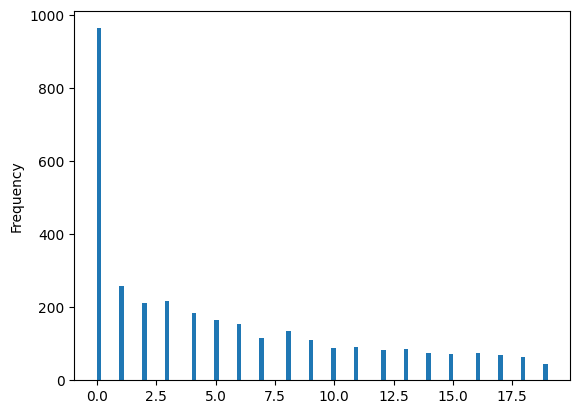

In [37]:
df[df.applicants_applications_count < 20]['applicants_applications_count'].plot(kind='hist', bins=100)

<Axes: ylabel='Frequency'>

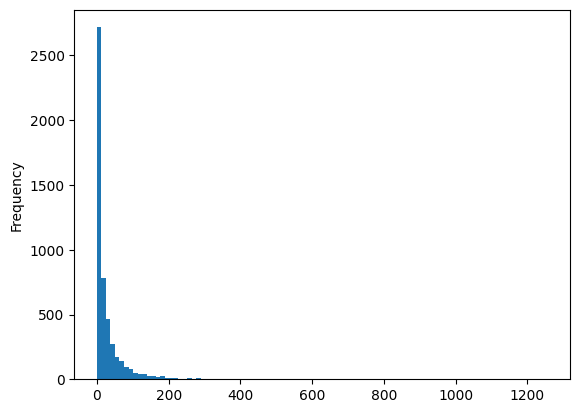

In [ ]:
df['applicants_applications_count'].plot(kind='hist', bins=100)

Inspecting data quality

- first_application_at and _last_applications_at and applicants_applications_count are reliable 

In [ ]:
# 1.0 -> always equal
(df.first_application_at.isna() == df.last_application_at.isna()).mean()

np.float64(0.9998094875214326)

In [ ]:
# 1.0 -> always equal
((df.applicants_applications_count == 0) == df.first_application_at.isna()).mean()

np.float64(0.9639931415507715)

In [ ]:
pd.DataFrame([df.live_since, df.deal_created_at]).T

,live_since,deal_created_at
0,2025-02-21 09:47:19.029007,2025-02-21 09:47:19.029007
1,2024-11-13 15:34:36.255346,2024-11-13 15:34:36.255346
2,2025-03-26 08:56:24.776549,2025-03-26 08:56:24.776549
3,2025-02-21 09:52:12.201945,2025-02-21 09:52:12.201945
4,2024-11-14 09:48:12.756236,2024-11-14 09:48:12.756236
...,...,...
5244,2025-09-26 08:43:28.977451,2025-09-26 08:38:26.476742
5245,2025-09-26 08:41:46.737392,2025-09-26 08:41:00.225417
5246,2025-09-26 08:42:34.385658,2025-09-26 08:42:34.271039
5247,2025-09-26 08:43:58.669002,2025-09-26 08:43:58.467887


In [ ]:
(df.live_since == df.deal_created_at).mean()

np.float64(0.4865688702610021)

In [ ]:
(df.live_since > df.deal_created_at).mean()

np.float64(0.3112973899790436)

# Applications within $n$ days after going live

TODO: NEED TO CHECK WHY I COUNT MORE APPLICATIONS WITHIN $N$ DAYS THAN TOTAL APPLICATIONS!!!

In [ ]:
query = 'SELECT * FROM public.deal_activity_logs;'
df_deals_log = pd.read_sql(query, engine)

query = 'SELECT * FROM public.deal_applications;'
df_applications = pd.read_sql(query, engine)

In [ ]:
df_deals_log.head()

,created_at,updated_at,deleted_at,id,entity_type,entity_id,action,before,after,metadata,entity_global_id
0,2025-06-14 04:00:00.320670,2025-07-11 14:40:32.801163,None,01976c98-2740-00cd-fe8b-f9c564ae29ac,deal,0196b417-9214-00c8-c0c6-9963c186bbe9,DEAL_UPDATE,"{'deal': {'SoftDeletable': {}, 'accepted_count...","{'deal': {'SoftDeletable': {}, 'accepted_count...",{'entity_global_id': '0196b417-9214-00c8-c0c6-...,0196b417-9214-00c8-c0c6-9963c186bbe9
1,2025-06-14 02:15:58.418330,2025-07-11 14:40:32.804326,None,01976c38-e8d2-00cd-879b-178e48af5364,deal_application,01976c38-e890-00c9-80a7-81b8b10c16aa,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '019689e2-fbdf-00c8-d5c1-...,019689e2-fbdf-00c8-d5c1-40a24b4b3293
2,2025-06-14 02:13:49.773612,2025-07-11 14:40:32.807938,None,01976c36-f24d-00cd-24a6-88f8f08e06c6,deal_application,01976c36-f202-00c9-5479-c9952c80441a,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '0196f838-48aa-00c8-9a89-...,0196f838-48aa-00c8-9a89-34ee3040956e
3,2025-06-14 01:04:27.294186,2025-07-11 14:40:32.811161,None,01976bf7-6e9d-00cd-b751-6b65c62a8130,deal_application,01976bf7-6e4e-00c9-0a9e-b972e4f37bdb,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '019689e3-e641-00c8-1f55-...,019689e3-e641-00c8-1f55-b6b12b26b56c
4,2025-06-14 00:26:58.841062,2025-07-11 14:40:32.813614,None,01976bd5-1f99-00cd-5bb1-832b23e07cb4,deal_application,01976bd5-1f85-00c9-aca4-f92e30696a43,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '0196f7d8-8767-00c8-238a-...,0196f7d8-8767-00c8-238a-5a7b9a9151ee


In [ ]:
df_applications.head()

,id,partner_id,location_id,deal_id,creator_id,rescheduling_deal_application_id,schedule_date,status,cancelled_at,cancelled_by,cancelled_by_user_id,cancellation_reason,created_at,updated_at,deleted_at,legacy_id,cancellation_remarks
0,019689f1-7415-00c9-24b7-84518a0961e7,621,917.0,019689e4-1e16-00c8-4e55-65179bcd2d0f,9865,None,2024-11-28 00:00:00+00:00,cancelled,NaT,None,NaN,None,2024-11-22 09:09:58.169246,2025-05-01 04:11:46.576683,NaT,81927.0,[other]
1,019689f1-7592-00c9-9aeb-d433209588f6,621,917.0,019689e4-1e16-00c8-4e55-65179bcd2d0f,1785,None,2024-10-24 00:00:00+00:00,cancelled,NaT,None,NaN,None,2024-10-16 13:37:21.088096,2025-05-01 04:11:46.583430,NaT,68073.0,[other]
2,0196a913-053f-00c9-3922-e06494e516db,1353,1978.0,019689e4-54cf-00c8-1971-b9e4e5d53267,11171,None,2025-05-31 22:00:00+00:00,finished,NaT,None,NaN,None,2025-05-07 04:48:38.207500,2025-06-16 08:50:59.574202,NaT,NaN,[other]
3,019689f1-76f3-00c9-fb12-33d26a910216,621,917.0,019689e4-1e16-00c8-4e55-65179bcd2d0f,2941,None,2025-01-30 00:00:00+00:00,rejected,NaT,None,NaN,None,2025-01-14 23:24:18.442362,2025-05-01 04:11:46.620078,NaT,97370.0,[other]
4,019689f2-260f-00c9-1450-f410ee9ae44f,331,391.0,019689e4-6f67-00c8-503a-25ec1f6e0517,11171,None,2025-05-16 00:00:00+00:00,rejected,2025-08-18 10:32:26.207049+00:00,partner,8658.0,,2025-04-13 06:37:53.268902,2025-08-18 10:32:26.207090,NaT,141924.0,[not_a_match]


Goal: 
- Use deal activity log to get reliable measure on deal popularity (as a measure for deal quality). Do this by measuring how many applications a deal gets in its first 7 days.


Methods:
- I can link the df_deals (df) with df_applications through deal_id. I can then count the nr of applications within $n$ days of live_since. Some deals are published to live multiple times, but this is a small amount, which I account for. 

Notes:
- entity_global_id (from metadata):
    - corresponds to a single deal
    - df_applications['deal_id']: entity_global_id = many:one



In [ ]:
# Get global id to match with records
df_deals_log.loc[:, 'entity_global_id'] = df_deals_log.apply(
    lambda x: x.metadata.get('entity_global_id'), axis=1)

In [ ]:
df

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,days_online,first_content_type
0,019689e1-dadd-00c8-5101-e0d07384f6dd,1170.0,- Vooraf spreken we een datum en tijd af. Zond...,0.0,3.0,2025-05-01 05:36:13.039280,2025-09-17 01:14:10.780239,NaT,1.0,019689e1-dadd-00c8-5101-e0d07384f6dd,...,0.0,0.0,False,[NLD],5000.0,2025-02-21 09:47:19.029007,NaT,019689e1-dadd-00c8-5101-e0d07384f6dd,176 days 23:44:57.870722,Food
1,019689e1-ddeb-00c8-5d08-8835332ab3e9,733.0,Engagement with your followers\nCreativity (no...,0.0,2.0,2025-05-01 05:36:13.124236,2025-05-27 06:45:33.892849,NaT,2.0,019689e1-ddeb-00c8-5d08-8835332ab3e9,...,0.0,0.0,False,[NLD],2500.0,2024-11-13 15:34:36.255346,NaT,019689e1-ddeb-00c8-5d08-8835332ab3e9,104 days 00:47:48.042719,UGC
2,019689e1-de33-00c8-297c-7a4241d57de4,745.0,-1 reel\n-1 static post\n-Share with us for ou...,0.0,2.0,2025-05-01 05:36:13.174210,2025-09-13 00:56:28.422154,NaT,3.0,019689e1-de33-00c8-297c-7a4241d57de4,...,0.0,0.0,False,[NLD],2500.0,2025-03-26 08:56:24.776549,NaT,019689e1-de33-00c8-297c-7a4241d57de4,112 days 04:34:31.874197,UGC
3,019689e1-e08f-00c8-c953-088b03df5152,1120.0,Stap 1: Laat zien hoe je schermtijd aankondigt...,0.0,2.0,2025-05-01 05:36:13.237112,2025-05-27 06:45:34.154721,NaT,4.0,019689e1-e08f-00c8-c953-088b03df5152,...,0.0,0.0,False,[NLD],2500.0,2025-02-21 09:52:12.201945,NaT,019689e1-e08f-00c8-c953-088b03df5152,13 days 01:24:43.493361,UGC
4,019689e1-e21b-00c8-2d1c-9c849e0682e4,744.0,- You are an experienced music maker\n- You ca...,0.0,2.0,2025-05-01 05:36:13.295605,2025-05-27 06:45:34.209060,NaT,5.0,019689e1-e21b-00c8-2d1c-9c849e0682e4,...,0.0,0.0,False,[NLD],2500.0,2024-11-14 09:48:12.756236,NaT,019689e1-e21b-00c8-2d1c-9c849e0682e4,11 days 22:09:24.263131,Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5244,0199852c-71ac-00c8-4ac4-1a07ce202740,2451.0,76n n76n 67n 76n 76n 67n,NaN,2.0,2025-09-26 08:38:27.645579,2025-09-26 08:44:37.839004,NaT,5160.0,0199852c-71ac-00c8-4ac4-1a07ce202740,...,0.0,0.0,False,[NLD],2500.0,2025-09-26 08:43:28.977451,NaT,0199852c-71ac-00c8-4ac4-1a07ce202740,NaT,Animals
5245,0199852e-ca41-00c8-9585-cff262aed8dd,2339.0,wefwefewfewfwef,NaN,34.0,2025-09-26 08:41:00.553328,2025-09-26 08:41:46.929541,NaT,5161.0,0199852e-ca41-00c8-9585-cff262aed8dd,...,0.0,0.0,False,[PRT],0.0,2025-09-26 08:41:46.737392,NaT,0199852e-ca41-00c8-9585-cff262aed8dd,NaT,Activities
5246,01998530-399f-00c8-3f00-d95b26bd2a56,2339.0,ergergergergerg,NaN,34.0,2025-09-26 08:42:34.511798,2025-09-26 08:42:34.511798,NaT,5162.0,01998530-399f-00c8-3f00-d95b26bd2a56,...,0.0,0.0,False,[PRT],0.0,2025-09-26 08:42:34.385658,NaT,01998530-399f-00c8-3f00-d95b26bd2a56,NaT,Activities
5247,01998531-8283-00c8-1aed-555491ce8f94,2338.0,fewfweqfweqfqwefqewfwefwef,0.0,34.0,2025-09-26 08:43:59.435614,2025-09-26 09:03:28.925991,NaT,5163.0,01998531-8283-00c8-1aed-555491ce8f94,...,0.0,0.0,False,[PRT],0.0,2025-09-26 08:43:58.669002,NaT,01998531-8283-00c8-1aed-555491ce8f94,NaT,Activities


In [ ]:
df_applications

,id,partner_id,location_id,deal_id,creator_id,rescheduling_deal_application_id,schedule_date,status,cancelled_at,cancelled_by,cancelled_by_user_id,cancellation_reason,created_at,updated_at,deleted_at,legacy_id,cancellation_remarks
0,019689f1-7415-00c9-24b7-84518a0961e7,621,917.0,019689e4-1e16-00c8-4e55-65179bcd2d0f,9865,None,2024-11-28 00:00:00+00:00,cancelled,NaT,None,NaN,None,2024-11-22 09:09:58.169246,2025-05-01 04:11:46.576683,NaT,81927.0,[other]
1,019689f1-7592-00c9-9aeb-d433209588f6,621,917.0,019689e4-1e16-00c8-4e55-65179bcd2d0f,1785,None,2024-10-24 00:00:00+00:00,cancelled,NaT,None,NaN,None,2024-10-16 13:37:21.088096,2025-05-01 04:11:46.583430,NaT,68073.0,[other]
2,0196a913-053f-00c9-3922-e06494e516db,1353,1978.0,019689e4-54cf-00c8-1971-b9e4e5d53267,11171,None,2025-05-31 22:00:00+00:00,finished,NaT,None,NaN,None,2025-05-07 04:48:38.207500,2025-06-16 08:50:59.574202,NaT,NaN,[other]
3,019689f1-76f3-00c9-fb12-33d26a910216,621,917.0,019689e4-1e16-00c8-4e55-65179bcd2d0f,2941,None,2025-01-30 00:00:00+00:00,rejected,NaT,None,NaN,None,2025-01-14 23:24:18.442362,2025-05-01 04:11:46.620078,NaT,97370.0,[other]
4,019689f2-260f-00c9-1450-f410ee9ae44f,331,391.0,019689e4-6f67-00c8-503a-25ec1f6e0517,11171,None,2025-05-16 00:00:00+00:00,rejected,2025-08-18 10:32:26.207049+00:00,partner,8658.0,,2025-04-13 06:37:53.268902,2025-08-18 10:32:26.207090,NaT,141924.0,[not_a_match]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195355,01998776-29b8-00c9-8de0-60f9ab925c14,871,NaN,019689e3-c95c-00c8-59d1-b20b75691f98,33338,None,NaT,waiting_approval,NaT,None,NaN,None,2025-09-26 19:18:12.152378,2025-09-26 19:18:12.152378,NaT,NaN,[other]
195356,01998776-5929-00c9-33b6-1b7a527786b4,1158,1728.0,019689e2-3356-00c8-ce54-f74d100de869,33338,None,2025-09-26 22:00:00+00:00,waiting_approval,NaT,None,NaN,None,2025-09-26 19:18:24.297445,2025-09-26 19:18:24.297445,NaT,NaN,[other]
195357,019987a1-5656-00c9-20c3-589433b514ae,679,1019.0,019689e3-30aa-00c8-4e8c-dbdc18cb558a,33338,None,2025-09-26 22:00:00+00:00,waiting_approval,NaT,None,NaN,None,2025-09-26 20:05:21.622612,2025-09-26 20:05:21.622612,NaT,NaN,[other]
195358,019987a2-44ad-00c9-f382-a11e430088a1,881,NaN,019689e3-cd07-00c8-623b-fcc04b68fc87,33338,None,NaT,waiting_approval,NaT,None,NaN,None,2025-09-26 20:06:22.637521,2025-09-26 20:06:22.637521,NaT,NaN,[other]


Question: is the live_since accurate? 

Method: Check whether all applications are from after live date

In [ ]:
def applications_before_live(row):  # astype UUID
    deal_id = row.deal_id
    live_since = row.live_since
    applications = df_applications[df_applications.deal_id == deal_id]

    return sum(applications.created_at <= live_since)

In [ ]:
df.loc[:, 'applications_before_live'] = df.apply(
    lambda x: applications_before_live(x), axis=1)

/var/folders/j6/_nwsrmhx5w1fj_nrxmrss8180000gq/T/ipykernel_84384/979908547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'applications_before_live'] = df.apply(lambda x: applications_before_live(x), axis=1)


Only a very small number of deals have applications before the deal went live, so this will have a very small effect on the analysis.

In [ ]:
(df.applications_before_live > 0).value_counts()

applications_before_live
False    4116
True       72
Name: count, dtype: int64

Function to compute the nr. of applications in the first 7 days after a deal has been published. Creators can apply for the same deal multiple times, leave those out for now. 

In [ ]:
days_since_live

20759     122
21189     122
21190     122
36148     136
36149     136
         ... 
179969    149
179970    149
179971    149
184702    159
191370    176
Name: created_at, Length: 72, dtype: int64

In [ ]:
(days_since_live <= 7)

20759     False
21189     False
21190     False
36148     False
36149     False
          ...  
179969    False
179970    False
179971    False
184702    False
191370    False
Name: created_at, Length: 72, dtype: bool

In [ ]:
((days_since_live >= 0) & (days_since_live <= 7)).sum()

np.int64(22)

In [ ]:
(days_since_live[days_since_live >= 0] <= 7).sum()

np.int64(22)

In [ ]:
sum(days_since_live[days_since_live >= 0] < 7)

19

In [ ]:
# Match applications to deals
df['deal_id_str'] = df['deal_id'].astype(str)

sample_id = df[~df.live_since.isna()].deal_id[0]
sample_live_since = df[~df.live_since.isna()].live_since[0]


def applications_since_live(row, n: int):  # astype UUID
    deal_id = row.deal_id
    live_since = row.live_since

    applications = df_applications[df_applications.deal_id == deal_id]
    # created_at: date when application is created, live_since: date when deal went live
    days_since_live = (applications.created_at - live_since).dt.days

    return ((days_since_live >= 0) & (days_since_live <= n)).sum()

    # return sum(days_since_live <= n & days_since_live >= 0)

    # applications_since_live = applications[applications.created_at >= live_since]
    # return len(applications_since_live)

In [ ]:
applications = df_applications[df_applications.deal_id == sample_id]
days_since_live = (applications.created_at - sample_live_since).dt.days

Around 25% of deals have no live_since date, I dont know why, but let's assume for now it's random and doesnt affect the analysis

In [ ]:
# beware, downstream df is not the same as upstream df
df = df[~df['live_since'].isna()]
df.loc[:, 'applications_till_day_7'] = df.apply(
    lambda x: applications_since_live(x, 7), axis=1)

In [ ]:
df.applications_till_day_7.describe()

count    4188.000000
mean       13.004059
std        19.840340
min         0.000000
25%         1.000000
50%         6.000000
75%        16.000000
max       188.000000
Name: applications_till_day_7, dtype: float64

20% of deals that do get applications, get no applications within the first 7 days:

In [ ]:
(df.applications_till_day_7 == 0).sum() / len(df)

np.float64(0.19436485195797518)

What is strange, is that many of these deals have a non-zero total application count. I will have to **investigate whether these are part of the application log at all**

In [ ]:
df[(df.applications_till_day_7 == 0)]

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,days_online,first_content_type,applications_before_live,applications_till_day_7
1,019689e1-ddeb-00c8-5d08-8835332ab3e9,733.0,Engagement with your followers\nCreativity (no...,0.0,2.0,2025-05-01 05:36:13.124236,2025-05-27 06:45:33.892849,NaT,2.0,019689e1-ddeb-00c8-5d08-8835332ab3e9,...,False,[NLD],2500.0,2024-11-13 15:34:36.255346,NaT,019689e1-ddeb-00c8-5d08-8835332ab3e9,104 days 00:47:48.042719,UGC,0,0
13,019689e1-e73f-00c8-d69f-154282baf51d,573.0,Wat verwachten we? \n✅ 1 video van max. 20 sec...,0.0,3.0,2025-05-01 05:36:14.324249,2025-09-20 21:15:47.473810,NaT,14.0,019689e1-e73f-00c8-d69f-154282baf51d,...,False,[NLD],5000.0,2025-02-21 12:30:43.166359,NaT,019689e1-e73f-00c8-d69f-154282baf51d,181 days 06:13:27.545598,Beauty,0,0
17,019689e1-e94a-00c8-d860-fccce5580ced,1156.0,Requirements:\n•\tHet filmpje is minimaal 15 s...,0.0,3.0,2025-05-01 05:36:14.520747,2025-07-10 10:39:34.378939,NaT,18.0,019689e1-e94a-00c8-d860-fccce5580ced,...,False,[NLD],5000.0,2025-07-10 10:39:33.977533,NaT,019689e1-e94a-00c8-d860-fccce5580ced,-94 days +08:55:57.436681,Activities,5,0
26,019689e1-ef1d-00c8-300e-dcca51ad7821,1396.0,We are looking for people to create a nice ree...,0.0,2.0,2025-05-01 05:36:15.466179,2025-06-20 06:33:15.661865,NaT,27.0,019689e1-ef1d-00c8-300e-dcca51ad7821,...,False,[NLD],2500.0,2025-03-26 13:19:45.891899,NaT,019689e1-ef1d-00c8-300e-dcca51ad7821,13 days 06:22:34.988037,Drinks,0,0
33,019689e1-f307-00c8-9458-5748fdac1b39,1221.0,"Look at the book, the stories, maps and photo'...",0.0,2.0,2025-05-01 05:36:16.087402,2025-05-27 06:45:36.380945,NaT,34.0,019689e1-f307-00c8-9458-5748fdac1b39,...,False,[NLD],2500.0,2025-02-22 10:34:33.573469,NaT,019689e1-f307-00c8-9458-5748fdac1b39,NaT,Experiences,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,019970f7-1c7f-00c8-f9c0-57060e56c7d4,2338.0,new deal again,100.0,1.0,2025-09-22 10:27:47.287109,2025-09-22 10:28:12.195035,NaT,5153.0,019970f7-1c7f-00c8-f9c0-57060e56c7d4,...,True,"[NLD, PRT, DNK]",1500.0,2025-09-22 10:28:11.975655,NaT,019970f7-1c7f-00c8-f9c0-57060e56c7d4,NaT,Beauty,0,0
5244,0199852c-71ac-00c8-4ac4-1a07ce202740,2451.0,76n n76n 67n 76n 76n 67n,NaN,2.0,2025-09-26 08:38:27.645579,2025-09-26 08:44:37.839004,NaT,5160.0,0199852c-71ac-00c8-4ac4-1a07ce202740,...,False,[NLD],2500.0,2025-09-26 08:43:28.977451,NaT,0199852c-71ac-00c8-4ac4-1a07ce202740,NaT,Animals,0,0
5245,0199852e-ca41-00c8-9585-cff262aed8dd,2339.0,wefwefewfewfwef,NaN,34.0,2025-09-26 08:41:00.553328,2025-09-26 08:41:46.929541,NaT,5161.0,0199852e-ca41-00c8-9585-cff262aed8dd,...,False,[PRT],0.0,2025-09-26 08:41:46.737392,NaT,0199852e-ca41-00c8-9585-cff262aed8dd,NaT,Activities,0,0
5246,01998530-399f-00c8-3f00-d95b26bd2a56,2339.0,ergergergergerg,NaN,34.0,2025-09-26 08:42:34.511798,2025-09-26 08:42:34.511798,NaT,5162.0,01998530-399f-00c8-3f00-d95b26bd2a56,...,False,[PRT],0.0,2025-09-26 08:42:34.385658,NaT,01998530-399f-00c8-3f00-d95b26bd2a56,NaT,Activities,0,0


# Applications per active days

Goal:
- Measure 'days online' by doing $'last \ application \ at'- 'live \ since'$. Then, calculate applications/days online. 
    - 'days online' is a proxy for how many days a deal is considered 'active'. 

Problems:
- Does not necessarily provide a unified measure (apples to apples):
    - Feed problems:
        - Algorithm of the feed is untransparant, but we know that a deal is most visible right after it's published. Some deals are created, drafted, then activated again, which might affect visibility and hence applications. Some deals are only online for very short and then taken offline, which introduces a lot of noise: popular products might get many applications, which rises their mean applications per day significantly. Therefore, I prefer to analyse the logs (which contain timestamps for each application and deal creation). 


Methods:
- Only check applications_count > 0, since we know for sure those deals have been active (change later maybe?)

In [ ]:
df.loc[:, 'days_online'] = df.last_application_at - df.live_since
df_zerodays = df[df.days_online.dt.days == 0]

In [ ]:
df_zerodays

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,last30_days_upcoming_applications_count,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,days_online
12,019689e1-e710-00c8-3882-e24589f27518,645.0,Een ugc video van jij die de art uitpakt en op...,0.0,2.0,2025-05-01 05:36:14.274141,2025-05-27 06:45:34.703496,NaT,13.0,019689e1-e710-00c8-3882-e24589f27518,...,0.0,0.0,0.0,False,[NLD],2500.0,2024-11-14 11:08:06.659935,NaT,019689e1-e710-00c8-3882-e24589f27518,0 days 02:56:51.950583
55,019689e1-fe47-00c8-f5fc-5b4d1fea8180,1333.0,Bekend zijn ivm Restaurant promoten,0.0,5.0,2025-05-01 05:36:17.800533,2025-05-27 06:45:37.994698,NaT,56.0,019689e1-fe47-00c8-f5fc-5b4d1fea8180,...,0.0,0.0,0.0,False,[NLD],25000.0,2025-03-26 17:20:24.657276,NaT,019689e1-fe47-00c8-f5fc-5b4d1fea8180,0 days 01:04:02.488262
90,019689e2-0ff1-00c8-62e0-c9a792423150,745.0,- one static post and one reel\n*must send con...,0.0,2.0,2025-05-01 05:36:20.152240,2025-05-27 06:45:41.051063,NaT,91.0,019689e2-0ff1-00c8-62e0-c9a792423150,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-24 11:04:23.007071,NaT,019689e2-0ff1-00c8-62e0-c9a792423150,0 days 08:38:08.533826
104,019689e2-170a-00c8-af00-1aab1fb3d527,745.0,- one static post and one reel\n*must send con...,0.0,2.0,2025-05-01 05:36:21.296615,2025-05-27 06:45:42.182764,NaT,105.0,019689e2-170a-00c8-af00-1aab1fb3d527,...,0.0,0.0,0.0,False,[NLD],2500.0,2025-02-24 13:39:09.169066,NaT,019689e2-170a-00c8-af00-1aab1fb3d527,0 days 06:22:59.298588
106,019689e2-177c-00c8-49df-4f674da3feeb,935.0,"SÛN is geschikt voor het hele gezin, sporters ...",0.0,5.0,2025-05-01 05:36:21.393159,2025-05-27 06:45:42.279001,NaT,106.0,019689e2-177c-00c8-49df-4f674da3feeb,...,0.0,0.0,0.0,False,[NLD],25000.0,2025-01-16 11:58:22.686879,NaT,019689e2-177c-00c8-49df-4f674da3feeb,0 days 09:18:53.966708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224,01995188-d84f-00c8-7fa3-3557fb798adf,2421.0,hrthrhtrthrthrtrhrthrt,100.0,34.0,2025-09-16 07:59:07.698751,2025-09-23 11:03:34.932544,NaT,5140.0,01995188-d84f-00c8-7fa3-3557fb798adf,...,1.0,0.0,0.0,False,[FRA],0.0,2025-09-16 07:59:07.089962,NaT,01995188-d84f-00c8-7fa3-3557fb798adf,0 days 00:00:42.074028
5225,01995225-7dbf-00c8-1493-3e09962ed842,2422.0,vdsvdsdvdvsddvdvs,100.0,34.0,2025-09-16 10:50:14.177348,2025-09-23 11:03:35.222291,NaT,5141.0,01995225-7dbf-00c8-1493-3e09962ed842,...,1.0,0.0,0.0,False,[FRA],0.0,2025-09-16 10:50:13.224042,NaT,01995225-7dbf-00c8-1493-3e09962ed842,0 days 00:01:23.597943
5226,0199522b-7f3e-00c8-c316-c7406eee1639,2423.0,abcdef abchdjkl,100.0,34.0,2025-09-16 10:56:47.474050,2025-09-23 11:03:35.327488,NaT,5142.0,0199522b-7f3e-00c8-c316-c7406eee1639,...,1.0,0.0,0.0,False,[FRA],0.0,2025-09-16 10:56:46.674387,NaT,0199522b-7f3e-00c8-c316-c7406eee1639,0 days 00:00:34.674774
5230,01995c1e-65a7-00c8-86ca-60654b4bf7e6,2432.0,I expect a video,100.0,34.0,2025-09-18 09:18:41.331488,2025-09-25 14:19:47.429052,NaT,5146.0,01995c1e-65a7-00c8-86ca-60654b4bf7e6,...,0.0,1.0,0.0,False,[FRA],0.0,2025-09-18 09:18:40.283303,NaT,01995c1e-65a7-00c8-86ca-60654b4bf7e6,0 days 00:00:35.292365


In [ ]:
df_zerodays.loc[:, 'hours_online'] = np.array(
    df_zerodays.days_online.dt.seconds / 3600)

/var/folders/j6/_nwsrmhx5w1fj_nrxmrss8180000gq/T/ipykernel_84384/139360255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zerodays.loc[:,'hours_online'] = np.array(df_zerodays.days_online.dt.seconds / 3600)


<Axes: ylabel='Frequency'>

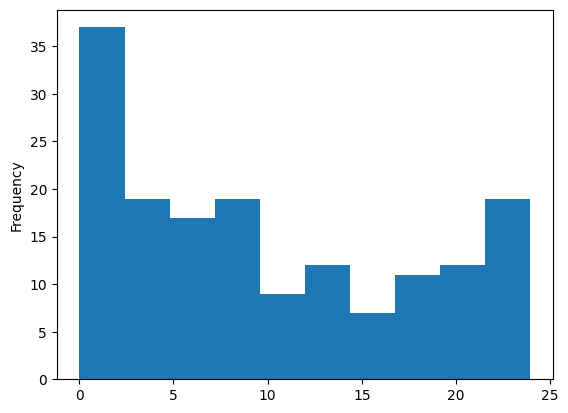

In [ ]:
df_zerodays.hours_online.plot(kind='hist')

<Axes: ylabel='Frequency'>

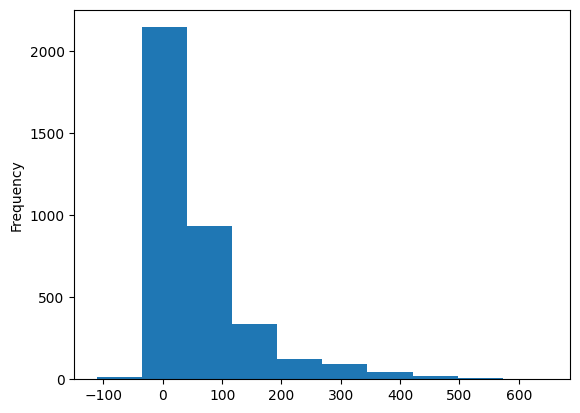

In [ ]:
df.days_online.dt.days.plot(kind='hist')

Tail is much too long. This will lead to bias. 

In [ ]:
# df.loc['applications_per_day'] = df.applicants_applications_count / df.days_online.dt.days

## Deal/applications activity log

In [ ]:
query = 'SELECT * FROM public.deal_activity_logs;'
df_deals_log = pd.read_sql(query, engine)

query = 'SELECT * FROM public.deal_applications;'
df_applications = pd.read_sql(query, engine)

In [ ]:
df_deals_log.head()

,created_at,updated_at,deleted_at,id,entity_type,entity_id,action,before,after,metadata
0,2025-06-14 04:00:00.320670,2025-07-11 14:40:32.801163,None,01976c98-2740-00cd-fe8b-f9c564ae29ac,deal,0196b417-9214-00c8-c0c6-9963c186bbe9,DEAL_UPDATE,"{'deal': {'SoftDeletable': {}, 'accepted_count...","{'deal': {'SoftDeletable': {}, 'accepted_count...",{'entity_global_id': '0196b417-9214-00c8-c0c6-...
1,2025-06-14 02:15:58.418330,2025-07-11 14:40:32.804326,None,01976c38-e8d2-00cd-879b-178e48af5364,deal_application,01976c38-e890-00c9-80a7-81b8b10c16aa,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '019689e2-fbdf-00c8-d5c1-...
2,2025-06-14 02:13:49.773612,2025-07-11 14:40:32.807938,None,01976c36-f24d-00cd-24a6-88f8f08e06c6,deal_application,01976c36-f202-00c9-5479-c9952c80441a,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '0196f838-48aa-00c8-9a89-...
3,2025-06-14 01:04:27.294186,2025-07-11 14:40:32.811161,None,01976bf7-6e9d-00cd-b751-6b65c62a8130,deal_application,01976bf7-6e4e-00c9-0a9e-b972e4f37bdb,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '019689e3-e641-00c8-1f55-...
4,2025-06-14 00:26:58.841062,2025-07-11 14:40:32.813614,None,01976bd5-1f99-00cd-5bb1-832b23e07cb4,deal_application,01976bd5-1f85-00c9-aca4-f92e30696a43,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '0196f7d8-8767-00c8-238a-...


Goal: 
- Use deal activity log to get reliable measure on deal popularity (as a measure for deal quality). Do this by measuring how many applications a deal gets in its first 7 days.

Problem:
- data on datetime in df_deals_log seems to come from after some database migration, so it is inaccurate. We need valid datetime to get the 'applications since publish' measurement. 

Methods:
- The metadata contains entity_global_id, which links to columns in tables which contain the correct data. By merging the right tables I can recreate the complete datatable that I need for the metric. 


Notes:
- entity_global_id (from metadata):
    - corresponds to a single deal
    - df_applications['deal_id']: entity_global_id = many:one



In [ ]:
df_deals_log.loc[:, 'entity_global_id'] = df_deals_log.apply(
    lambda x: x.metadata.get('entity_global_id'), axis=1)

In [ ]:
# Look at df_applications first, might not need df_deals_log


df['deal_id_str'] = df['deal_id'].astype(str)

sample_id = df[~df.live_since.isna()].deal_id[0]


def applications_since_live(row, n: int):  # astype UUID
    deal_id = row.deal_id
    live_since = row.live_since

    applications = df_applications[df_applications.deal_id == deal_id]

    days_since_live = (applications.created_at - live_since).dt.days

    return sum(days_since_live <= n)

    # applications_since_live = applications[applications.created_at >= live_since]
    # return len(applications_since_live)

In [ ]:
df[~df['live_since'].isna()]

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,days_online,first_content_type
0,019689e1-dadd-00c8-5101-e0d07384f6dd,1170.0,- Vooraf spreken we een datum en tijd af. Zond...,0.0,3.0,2025-05-01 05:36:13.039280,2025-09-17 01:14:10.780239,NaT,1.0,019689e1-dadd-00c8-5101-e0d07384f6dd,...,0.0,0.0,False,[NLD],5000.0,2025-02-21 09:47:19.029007,NaT,019689e1-dadd-00c8-5101-e0d07384f6dd,176 days 23:44:57.870722,Food
1,019689e1-ddeb-00c8-5d08-8835332ab3e9,733.0,Engagement with your followers\nCreativity (no...,0.0,2.0,2025-05-01 05:36:13.124236,2025-05-27 06:45:33.892849,NaT,2.0,019689e1-ddeb-00c8-5d08-8835332ab3e9,...,0.0,0.0,False,[NLD],2500.0,2024-11-13 15:34:36.255346,NaT,019689e1-ddeb-00c8-5d08-8835332ab3e9,104 days 00:47:48.042719,UGC
2,019689e1-de33-00c8-297c-7a4241d57de4,745.0,-1 reel\n-1 static post\n-Share with us for ou...,0.0,2.0,2025-05-01 05:36:13.174210,2025-09-13 00:56:28.422154,NaT,3.0,019689e1-de33-00c8-297c-7a4241d57de4,...,0.0,0.0,False,[NLD],2500.0,2025-03-26 08:56:24.776549,NaT,019689e1-de33-00c8-297c-7a4241d57de4,112 days 04:34:31.874197,UGC
3,019689e1-e08f-00c8-c953-088b03df5152,1120.0,Stap 1: Laat zien hoe je schermtijd aankondigt...,0.0,2.0,2025-05-01 05:36:13.237112,2025-05-27 06:45:34.154721,NaT,4.0,019689e1-e08f-00c8-c953-088b03df5152,...,0.0,0.0,False,[NLD],2500.0,2025-02-21 09:52:12.201945,NaT,019689e1-e08f-00c8-c953-088b03df5152,13 days 01:24:43.493361,UGC
4,019689e1-e21b-00c8-2d1c-9c849e0682e4,744.0,- You are an experienced music maker\n- You ca...,0.0,2.0,2025-05-01 05:36:13.295605,2025-05-27 06:45:34.209060,NaT,5.0,019689e1-e21b-00c8-2d1c-9c849e0682e4,...,0.0,0.0,False,[NLD],2500.0,2024-11-14 09:48:12.756236,NaT,019689e1-e21b-00c8-2d1c-9c849e0682e4,11 days 22:09:24.263131,Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5239,019971cb-0abd-00c8-6d46-c712fb5eb572,2354.0,mais uma moeda mais uma volta,0.0,34.0,2025-09-22 14:19:17.188251,2025-09-30 01:23:50.229380,NaT,5155.0,019971cb-0abd-00c8-6d46-c712fb5eb572,...,0.0,0.0,False,[PRT],0.0,2025-09-22 14:19:16.286391,NaT,019971cb-0abd-00c8-6d46-c712fb5eb572,0 days 00:00:36.273320,Activities
5244,0199852c-71ac-00c8-4ac4-1a07ce202740,2451.0,76n n76n 67n 76n 76n 67n,NaN,2.0,2025-09-26 08:38:27.645579,2025-09-26 08:44:37.839004,NaT,5160.0,0199852c-71ac-00c8-4ac4-1a07ce202740,...,0.0,0.0,False,[NLD],2500.0,2025-09-26 08:43:28.977451,NaT,0199852c-71ac-00c8-4ac4-1a07ce202740,NaT,Animals
5245,0199852e-ca41-00c8-9585-cff262aed8dd,2339.0,wefwefewfewfwef,NaN,34.0,2025-09-26 08:41:00.553328,2025-09-26 08:41:46.929541,NaT,5161.0,0199852e-ca41-00c8-9585-cff262aed8dd,...,0.0,0.0,False,[PRT],0.0,2025-09-26 08:41:46.737392,NaT,0199852e-ca41-00c8-9585-cff262aed8dd,NaT,Activities
5246,01998530-399f-00c8-3f00-d95b26bd2a56,2339.0,ergergergergerg,NaN,34.0,2025-09-26 08:42:34.511798,2025-09-26 08:42:34.511798,NaT,5162.0,01998530-399f-00c8-3f00-d95b26bd2a56,...,0.0,0.0,False,[PRT],0.0,2025-09-26 08:42:34.385658,NaT,01998530-399f-00c8-3f00-d95b26bd2a56,NaT,Activities


In [ ]:
df[df['live_since'].isna()]

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,days_online,first_content_type
10,019689e1-e574-00c8-07f4-5a40bf8f73ce,645.0,Een ugc video van jij die de art uitpakt en op...,0.0,2.0,2025-05-01 05:36:14.042418,2025-05-26 02:44:35.272813,2025-05-26 11:41:16.293000+00:00,11.0,019689e1-e574-00c8-07f4-5a40bf8f73ce,...,0.0,0.0,False,[NLD],2500.0,NaT,NaT,019689e1-e574-00c8-07f4-5a40bf8f73ce,NaT,UGC
15,019689e1-e8ab-00c8-41cb-4e11fa46e4ef,645.0,Een ugc video van jij die de art uitpakt en op...,0.0,2.0,2025-05-01 05:36:14.419523,2025-05-06 20:39:31.293447,2025-05-26 11:41:16.293000+00:00,16.0,019689e1-e8ab-00c8-41cb-4e11fa46e4ef,...,0.0,0.0,False,[NLD],2500.0,NaT,NaT,019689e1-e8ab-00c8-41cb-4e11fa46e4ef,NaT,UGC
38,019689e1-f59f-00c8-1b3d-75ef330d53d7,727.0,Wat we graag willen is een leuk filmpje van de...,0.0,5.0,2025-05-01 05:36:16.349006,2025-05-06 00:39:31.135112,2025-05-26 11:41:16.293000+00:00,39.0,019689e1-f59f-00c8-1b3d-75ef330d53d7,...,0.0,0.0,False,[NLD],25000.0,NaT,NaT,019689e1-f59f-00c8-1b3d-75ef330d53d7,NaT,Experiences
41,019689e1-f6c7-00c8-7303-783e11ad292f,1014.0,- De eerste post moet binnen 2 weken na ontvan...,0.0,2.0,2025-05-01 05:36:16.597324,2025-05-06 20:39:32.865374,2025-05-26 11:41:16.293000+00:00,42.0,019689e1-f6c7-00c8-7303-783e11ad292f,...,0.0,0.0,False,[NLD],2500.0,NaT,NaT,019689e1-f6c7-00c8-7303-783e11ad292f,NaT,UGC
47,019689e1-fa51-00c8-7202-7200e0968c5a,819.0,Video van minimaal 30 sec.\nAlleen het gemaakt...,0.0,3.0,2025-05-01 05:36:17.133354,2025-05-01 13:55:44.632562,2025-05-26 11:41:16.293000+00:00,48.0,019689e1-fa51-00c8-7202-7200e0968c5a,...,0.0,0.0,False,[NLD],5000.0,NaT,NaT,019689e1-fa51-00c8-7202-7200e0968c5a,NaT,Cooking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5240,0199755f-5f85-00c8-246a-1d09ea5b8696,2435.0,give away shoes,0.0,34.0,2025-09-23 07:00:09.543002,2025-09-23 07:00:09.543002,NaT,5156.0,0199755f-5f85-00c8-246a-1d09ea5b8696,...,0.0,0.0,True,[],0.0,NaT,NaT,0199755f-5f85-00c8-246a-1d09ea5b8696,NaT,Music
5241,01997cbf-948a-00c8-de6c-23ce8e4b862e,2338.0,test deal 2025,250.0,34.0,2025-09-24 17:22:35.144723,2025-09-24 17:37:05.349279,NaT,5157.0,01997cbf-948a-00c8-de6c-23ce8e4b862e,...,0.0,0.0,True,"[DNK, PRT, ESP, GBR]",0.0,NaT,NaT,01997cbf-948a-00c8-de6c-23ce8e4b862e,NaT,Activities
5242,01997cc0-a2c4-00c8-941d-5a8812f4c835,2338.0,test deal 2025,0.0,34.0,2025-09-24 17:23:44.370381,2025-09-24 17:23:44.370381,NaT,5158.0,01997cc0-a2c4-00c8-941d-5a8812f4c835,...,0.0,0.0,True,"[PRT, GBR, BEL]",0.0,NaT,NaT,01997cc0-a2c4-00c8-941d-5a8812f4c835,NaT,Activities
5243,0199825d-7b75-00c8-8a8b-82463cbde072,2459.0,"Post 1 detailed Instagram Reel, 3-5 Instagram ...",4861.0,1.0,2025-09-25 19:33:09.453969,2025-09-25 19:33:09.453969,NaT,5159.0,0199825d-7b75-00c8-8a8b-82463cbde072,...,0.0,0.0,False,[NLD],1500.0,NaT,NaT,0199825d-7b75-00c8-8a8b-82463cbde072,NaT,Animals


In [ ]:
df2 = df[~df['live_since'].isna()]

In [ ]:
df2.loc[:, 'applications_till_day_7'] = df2.apply(
    lambda x: applications_since_live(x, 7), axis=1)

/var/folders/j6/_nwsrmhx5w1fj_nrxmrss8180000gq/T/ipykernel_84384/2757061896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'applications_till_day_7'] = df2.apply(lambda x: applications_since_live(x, 7), axis=1)


In [ ]:
df2.loc[:, 'accepted_countries_str'] = df2['accepted_countries'].apply(
    lambda x: x[0] if len(x) > 0 else np.nan)

/var/folders/j6/_nwsrmhx5w1fj_nrxmrss8180000gq/T/ipykernel_84384/783529440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'accepted_countries_str'] = df2['accepted_countries'].apply(lambda x: x[0] if len(x) > 0 else np.nan)


In [ ]:
df2.loc[:, 'first_content_type'] = df2.content_types.apply(
    lambda x: x[0]['name'] if type(x) is list else "None")

In [ ]:
df2.accepts_international

0       False
1       False
2       False
3       False
4       False
        ...  
5239    False
5244    False
5245    False
5246    False
5247    False
Name: accepts_international, Length: 4188, dtype: object

In [ ]:
X

,deal_type_physical,accepts_international_True,first_content_type_Animals,first_content_type_Beauty,first_content_type_Cars,first_content_type_Cooking,first_content_type_Drinks,first_content_type_Entertainment,first_content_type_Experiences,first_content_type_Fashion,...,first_content_type_Mom,first_content_type_Movie,first_content_type_Music,first_content_type_Nightlife,first_content_type_Photography,first_content_type_Sport,first_content_type_Tech,first_content_type_Travel,first_content_type_UGC,first_content_type_Vegan
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5231,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5237,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: ylabel='Frequency'>

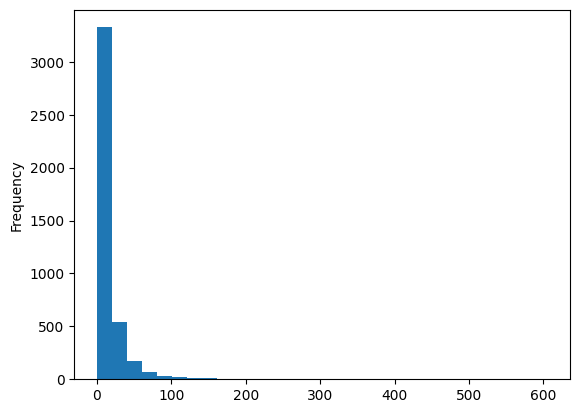

In [ ]:
df2.applications_till_day_7.plot(kind='hist', bins=30)

In [ ]:
import pandas as pd
import statsmodels.api as sm

cols_of_interest = [
    'deal_type',
    # 'content_types',
    'accepts_international',
    'accepted_countries_str',
    # 'min_social_media_followers',
    'first_content_type'
]

# Drop rows with missing values in the target or predictors (optional)
df_model = df2[['applications_till_day_7'] + cols_of_interest].dropna()

df_model = df_model[df_model.accepted_countries_str == 'NLD']

# Convert categorical predictors into dummy variables
X = pd.get_dummies(df_model[cols_of_interest], drop_first=True, dtype=int)
# X.loc[:,'accepts_international'] = X.accepts_international.astype('int')

# Add constant for intercept
X = sm.add_constant(X)

# Define dependent variable
y = df_model['applications_till_day_7']

# ### 1. OLS baseline
# ols_model = sm.OLS(y, X).fit()
# print("\n--- OLS ---")
# print(ols_model.summary())

# ### 2. Poisson regression
# poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
# print("\n--- Poisson ---")
# print(poisson_model.summary())

# 3. Negative Binomial regression
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
print("\n--- Negative Binomial ---")
print(nb_model.summary())


--- Negative Binomial ---
                    Generalized Linear Model Regression Results                    
Dep. Variable:     applications_till_day_7   No. Observations:                 3193
Model:                                 GLM   Df Residuals:                     3167
Model Family:             NegativeBinomial   Df Model:                           25
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -11756.
Date:                     Tue, 30 Sep 2025   Deviance:                       5560.9
Time:                             13:44:37   Pearson chi2:                 7.46e+03
No. Iterations:                          8   Pseudo R-squ. (CS):             0.1125
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

/Users/wouterbarter/Documents/GitHub/AI_thesis-1/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


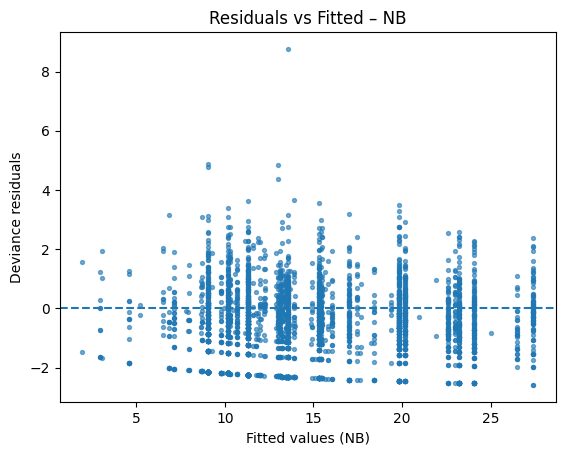

In [ ]:
import matplotlib.pyplot as plt
res = nb_model
fitted = res.fittedvalues
resid = res.resid_deviance
plt.figure()
plt.scatter(fitted, resid, s=8, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel(f"Fitted values ({'NB'})")
plt.ylabel("Deviance residuals")
plt.title(f"Residuals vs Fitted – {'NB'}")
plt.show()

Total zeros: 525
Zeros lying on floor (within tol): 525
Non-zeros lying on floor (within tol): 0


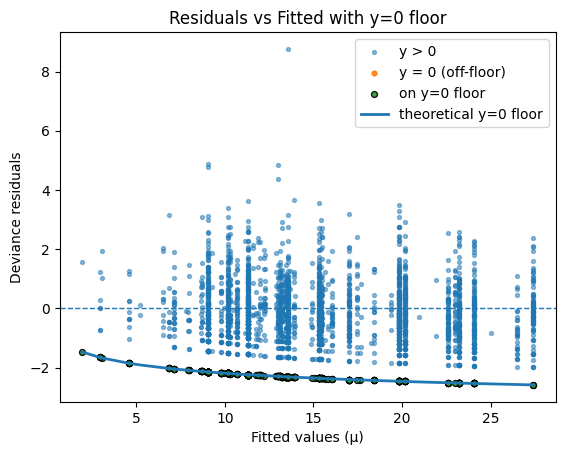

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

res = nb_model        # or "Poisson"
mu = res.fittedvalues           # fitted means
r = res.resid_deviance         # deviance residuals

# Your original target as a pandas Series/array aligned to the fit:
y_arr = y.values if hasattr(y, "values") else np.asarray(y)
is_zero = (y_arr == 0)

# Choose the boundary for your family:
if hasattr(res.model.family, "alpha"):            # NB
    alpha = res.model.family.alpha                # default 1.0 unless you set it
    r_floor = -np.sqrt((2.0/alpha) * np.log1p(alpha*mu))
else:                                             # Poisson
    r_floor = -np.sqrt(2.0*mu)

# Distance to the floor
diff = np.abs(r - r_floor)

# Pick a small tolerance (adjust if needed)
tol = 1e-6  # start extremely tight; if nothing matches, try 1e-3 or 1e-2
on_floor = diff < tol

# Counts
n_zero = is_zero.sum()
n_zero_on_floor = np.logical_and(is_zero, on_floor).sum()
n_nonzero_on_floor = np.logical_and(~is_zero, on_floor).sum()

print(f"Total zeros: {n_zero}")
print(f"Zeros lying on floor (within tol): {n_zero_on_floor}")
print(f"Non-zeros lying on floor (within tol): {n_nonzero_on_floor}")

# Plot
plt.figure()
plt.scatter(mu[~is_zero], r[~is_zero], s=8, alpha=0.5, label="y > 0")
plt.scatter(mu[is_zero & ~on_floor], r[is_zero & ~on_floor],
            s=12, alpha=0.9, label="y = 0 (off-floor)")
plt.scatter(mu[on_floor], r[on_floor], s=18, alpha=0.9,
            edgecolor="k", label="on y=0 floor")
# overlay the theoretical floor curve
order = np.argsort(mu)
plt.plot(mu.iloc[order] if hasattr(mu, "iloc") else mu[order],
         (r_floor.iloc[order] if hasattr(r_floor, "iloc") else r_floor[order]),
         linewidth=2, label="theoretical y=0 floor")
plt.axhline(0, ls="--", linewidth=1)
plt.xlabel("Fitted values (μ)")
plt.ylabel("Deviance residuals")
plt.title("Residuals vs Fitted with y=0 floor")
plt.legend()
plt.show()

Analyse why we overpredict so many $y=0$

In [ ]:
df2[df2.applicants_applications_count == 0]

,id_x,partner_id_x,creators_requirement,deal_value,social_requirement_type_id,created_at,updated_at,deleted_at,id_y,deal_id,...,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until,deal_id_str,days_online,applications_till_day_7,accepted_countries_str,first_content_type
16,019689e1-e8ec-00c8-afda-5b22efc736c8,1104.0,- 1 unboxing video op Instagram en TikTok\n- 1...,0.0,3.0,2025-05-01 05:36:14.470787,2025-05-27 06:45:34.926328,NaT,17.0,019689e1-e8ec-00c8-afda-5b22efc736c8,...,False,[NLD],5000.0,2025-02-21 12:30:53.965962,NaT,019689e1-e8ec-00c8-afda-5b22efc736c8,NaT,11,NLD,Luxury
24,019689e1-eda6-00c8-db19-2eced64d8bad,1127.0,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.292943,2025-05-27 06:45:35.484568,NaT,25.0,019689e1-eda6-00c8-db19-2eced64d8bad,...,False,[NLD],2500.0,2025-02-22 07:53:36.034463,NaT,019689e1-eda6-00c8-db19-2eced64d8bad,NaT,4,NLD,Cooking
27,019689e1-efca-00c8-9414-75bb2889b288,1127.0,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.558393,2025-05-27 06:45:35.789052,NaT,28.0,019689e1-efca-00c8-9414-75bb2889b288,...,False,[NLD],2500.0,2025-02-22 08:11:38.874922,NaT,019689e1-efca-00c8-9414-75bb2889b288,NaT,10,NLD,Cooking
31,019689e1-f199-00c8-42f5-32b723f9d221,1127.0,Wat voor type influencer zoeken wij?\n\nWij zi...,0.0,2.0,2025-05-01 05:36:15.949964,2025-05-27 06:45:36.249777,NaT,32.0,019689e1-f199-00c8-42f5-32b723f9d221,...,False,[NLD],2500.0,2025-02-22 08:27:21.868747,NaT,019689e1-f199-00c8-42f5-32b723f9d221,NaT,6,NLD,Experiences
33,019689e1-f307-00c8-9458-5748fdac1b39,1221.0,"Look at the book, the stories, maps and photo'...",0.0,2.0,2025-05-01 05:36:16.087402,2025-05-27 06:45:36.380945,NaT,34.0,019689e1-f307-00c8-9458-5748fdac1b39,...,False,[NLD],2500.0,2025-02-22 10:34:33.573469,NaT,019689e1-f307-00c8-9458-5748fdac1b39,NaT,0,NLD,Experiences
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,019970f7-1c7f-00c8-f9c0-57060e56c7d4,2338.0,new deal again,100.0,1.0,2025-09-22 10:27:47.287109,2025-09-22 10:28:12.195035,NaT,5153.0,019970f7-1c7f-00c8-f9c0-57060e56c7d4,...,True,"[NLD, PRT, DNK]",1500.0,2025-09-22 10:28:11.975655,NaT,019970f7-1c7f-00c8-f9c0-57060e56c7d4,NaT,0,NLD,Beauty
5244,0199852c-71ac-00c8-4ac4-1a07ce202740,2451.0,76n n76n 67n 76n 76n 67n,NaN,2.0,2025-09-26 08:38:27.645579,2025-09-26 08:44:37.839004,NaT,5160.0,0199852c-71ac-00c8-4ac4-1a07ce202740,...,False,[NLD],2500.0,2025-09-26 08:43:28.977451,NaT,0199852c-71ac-00c8-4ac4-1a07ce202740,NaT,0,NLD,Animals
5245,0199852e-ca41-00c8-9585-cff262aed8dd,2339.0,wefwefewfewfwef,NaN,34.0,2025-09-26 08:41:00.553328,2025-09-26 08:41:46.929541,NaT,5161.0,0199852e-ca41-00c8-9585-cff262aed8dd,...,False,[PRT],0.0,2025-09-26 08:41:46.737392,NaT,0199852e-ca41-00c8-9585-cff262aed8dd,NaT,0,PRT,Activities
5246,01998530-399f-00c8-3f00-d95b26bd2a56,2339.0,ergergergergerg,NaN,34.0,2025-09-26 08:42:34.511798,2025-09-26 08:42:34.511798,NaT,5162.0,01998530-399f-00c8-3f00-d95b26bd2a56,...,False,[PRT],0.0,2025-09-26 08:42:34.385658,NaT,01998530-399f-00c8-3f00-d95b26bd2a56,NaT,0,PRT,Activities


In [ ]:
def irr_table(glm_res):
    """
    For GLM (Poisson / NegBin): returns IRR = exp(beta) with 95% CI and p-values.
    """
    params = glm_res.params
    conf = glm_res.conf_int()
    irr = np.exp(params)
    irr_ci_lower = np.exp(conf[0])
    irr_ci_upper = np.exp(conf[1])
    out = pd.DataFrame({
        "IRR": irr,
        "CI_lower": irr_ci_lower,
        "CI_upper": irr_ci_upper,
        "p_value": glm_res.pvalues
    })
    return out

In [ ]:
irr_table(nb_model)

,IRR,CI_lower,CI_upper,p_value
const,13.552749,12.279216,14.958367,0.000000e+00
deal_type_physical,0.666536,0.611760,0.726215,1.830992e-20
accepts_international_True,1.139667,1.025552,1.266480,1.515378e-02
first_content_type_Animals,0.875237,0.560890,1.365759,5.572219e-01
first_content_type_Beauty,1.488544,1.275326,1.737409,4.576489e-07
first_content_type_Cars,0.339319,0.209357,0.549958,1.150625e-05
first_content_type_Cooking,0.790787,0.631870,0.989672,4.029985e-02
first_content_type_Drinks,1.129262,0.893131,1.427823,3.097870e-01
first_content_type_Entertainment,0.884780,0.624694,1.253151,4.906321e-01
first_content_type_Experiences,1.128468,0.984747,1.293165,8.206549e-02


In [ ]:
poisson_model.aic

np.float64(76382.29433168346)

In [ ]:
nb_model.aic

np.float64(23563.92228097735)

In [ ]:
import statsmodels.api as sm

# y and X from your OLS code
model_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
print(model_nb.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     applications_till_day_7   No. Observations:                 3192
Model:                                 GLM   Df Residuals:                     3189
Model Family:             NegativeBinomial   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -11848.
Date:                     Tue, 23 Sep 2025   Deviance:                       5742.5
Time:                             16:49:52   Pearson chi2:                 6.95e+03
No. Iterations:                          6   Pseudo R-squ. (CS):            0.05839
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

/Users/wouterbarter/Documents/GitHub/AI_thesis-1/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [ ]:
cols_of_interest = ['deal_type', 'content_types', 'accepts_international',
                    'accepted_countries', 'min_social_media_followers']

In [ ]:
df.assign(applications_since_live_7=lambda x: applications_since_live(x, 7), axis=1)

ValueError: Can only compare identically-labeled Series objects

In [ ]:
applications_since_live()

In [ ]:
sample_id

UUID('019689e3-1e49-00c8-7255-e6645e0ea062')

In [ ]:
df_applications.deal_id[0]

UUID('019689e4-1e16-00c8-4e55-65179bcd2d0f')

In [ ]:
df_applications[df_applications.deal_id == sample_id].created_at

25937   2024-12-05 18:29:22.087300
25938   2024-12-29 01:41:42.330750
Name: created_at, dtype: datetime64[ns]

In [ ]:
df.live_since[0]

Timestamp('2024-12-04 10:44:12.439001')

In [ ]:
a = (df_applications[df_applications.deal_id ==
     sample_id].created_at - df.live_since[0]).dt.days

In [ ]:
sum(a <= 7)

1

--------------

In [ ]:
def get_entity_id(row):
    try:
        # Check the 'entity_type' column of the current row
        if row['entity_type'] == 'deal':
            # If it's a 'deal', look inside the 'after' column for the deal ID
            return row['after']['deal']['id']

        elif row['entity_type'] == 'deal_application':
            # If it's a 'deal_application', get the application ID
            return row['after']['application']['deal_id']

        # If entity_type is something else, we return None
        return None

    except (TypeError, KeyError):
        # This handles cases where 'after' is None or the keys are missing
        return None


# --- Apply the function to each ROW using axis=1 ---
df_deals_log.loc[:, 'deal_id'] = df_deals_log.apply(get_entity_id, axis=1)

df_deals_log

,created_at,updated_at,deleted_at,id,entity_type,entity_id,action,before,after,metadata,deal_id,asdfasdf
0,2025-06-14 04:00:00.320670,2025-07-11 14:40:32.801163,None,01976c98-2740-00cd-fe8b-f9c564ae29ac,deal,01JTT1F4GM034C1HMSCF0RDEZ9,DEAL_UPDATE,"{'deal': {'SoftDeletable': {}, 'accepted_count...","{'deal': {'SoftDeletable': {}, 'accepted_count...",{'entity_global_id': '0196b417-9214-00c8-c0c6-...,01JTT1F4GM034C1HMSCF0RDEZ9,01JTT1F4GM034C1HMSCF0RDEZ9
1,2025-06-14 02:15:58.418330,2025-07-11 14:40:32.804326,None,01976c38-e8d2-00cd-879b-178e48af5364,deal_application,01JT4Y5YYZ034DBGA0M95MPCMK,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '019689e2-fbdf-00c8-d5c1-...,01JT4Y5YYZ034DBGA0M95MPCMK,01JT4Y5YYZ034DBGA0M95MPCMK
2,2025-06-14 02:13:49.773612,2025-07-11 14:40:32.807938,None,01976c36-f24d-00cd-24a6-88f8f08e06c6,deal_application,01JVW3GJ5A0349N29MXRR415BE,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '0196f838-48aa-00c8-9a89-...,01JVW3GJ5A0349N29MXRR415BE,01JVW3GJ5A0349N29MXRR415BE
3,2025-06-14 01:04:27.294186,2025-07-11 14:40:32.811161,None,01976bf7-6e9d-00cd-b751-6b65c62a8130,deal_application,01JT4Y7SJ10341YNDPP4NJDDBC,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '019689e3-e641-00c8-1f55-...,01JT4Y7SJ10341YNDPP4NJDDBC,01JT4Y7SJ10341YNDPP4NJDDBC
4,2025-06-14 00:26:58.841062,2025-07-11 14:40:32.813614,None,01976bd5-1f99-00cd-5bb1-832b23e07cb4,deal_application,01JVVXH1V7034272JTFED92MFE,DEAL_APPLICATION_CREATED,"{'application': {'SoftDeletable': {}, 'cancell...","{'application': {'SoftDeletable': {}, 'cancell...",{'entity_global_id': '0196f7d8-8767-00c8-238a-...,01JVVXH1V7034272JTFED92MFE,01JVVXH1V7034272JTFED92MFE
...,...,...,...,...,...,...,...,...,...,...,...,...
81259,2025-09-22 10:28:05.217922,2025-09-22 10:28:05.217922,None,019970f7-63e1-00cd-bf1b-32750e17c6da,deal,01K5RFE73Z034FKG2Q0R75DHYM,DEAL_UPDATE,{'deal': {'SoftDeletable': {'created_at': '202...,{'deal': {'SoftDeletable': {'created_at': '202...,{'entity_global_id': '019970f7-1c7f-00c8-f9c0-...,01K5RFE73Z034FKG2Q0R75DHYM,01K5RFE73Z034FKG2Q0R75DHYM
81260,2025-09-22 10:28:11.802925,2025-09-22 10:28:11.802925,None,019970f7-7d9a-00cd-8a27-a9c4fc3275d8,deal,01K5RFE73Z034FKG2Q0R75DHYM,DEAL_UPDATE,{'deal': {'SoftDeletable': {'created_at': '202...,{'deal': {'SoftDeletable': {'created_at': '202...,{'entity_global_id': '019970f7-1c7f-00c8-f9c0-...,01K5RFE73Z034FKG2Q0R75DHYM,01K5RFE73Z034FKG2Q0R75DHYM
81261,2025-09-22 10:28:12.039075,2025-09-22 10:28:12.039075,None,019970f7-7e87-00cd-8536-adc7cd18186a,deal,01K5RFE73Z034FKG2Q0R75DHYM,DEAL_UPDATE,{'deal': {'SoftDeletable': {'created_at': '202...,{'deal': {'SoftDeletable': {'created_at': '202...,{'entity_global_id': '019970f7-1c7f-00c8-f9c0-...,01K5RFE73Z034FKG2Q0R75DHYM,01K5RFE73Z034FKG2Q0R75DHYM
81262,2025-09-22 10:28:24.399424,2025-09-22 10:28:24.399424,None,019970f7-aecf-00cd-46a9-ec81f924ece4,deal,01K5RFFBMC034CRA8CTD8EPNEM,DEAL_CREATE,{'version': 1},{'deal': {'SoftDeletable': {'created_at': '202...,{'entity_global_id': '019970f7-ae8c-00c8-cc29-...,01K5RFFBMC034CRA8CTD8EPNEM,01K5RFFBMC034CRA8CTD8EPNEM


In [ ]:
df_deals_log.action.value_counts()

action
DEAL_APPLICATION_CREATED      44366
DEAL_APPLICATION_REJECTED     12055
DEAL_UPDATE                    7870
DEAL_APPLICATION_ACCEPTED      6787
DEAL_MIGRATED                  3440
DEAL_APPLICATION_CANCELLED     3050
DEAL_CREATE                    1799
DEAL_TAG_ADDED                  955
DEAL_TAG_REMOVED                941
DEAL_TAG_UPDATED                  1
Name: count, dtype: int64

In [ ]:
a = set(df.deal_id.astype(str)) & set(df_deals_log.entity_global_id)

AttributeError: 'DataFrame' object has no attribute 'entity_global_id'

In [ ]:
df_deals_log.id[0]

UUID('01976c98-2740-00cd-fe8b-f9c564ae29ac')

# Analysis

## Patterns in application count

# Rest

- Subset deals that have applications

In [ ]:
df = df.query('applicants_applications_count > 0')

,created_at,updated_at,deleted_at,id,deal_id,title,description,partner_id,locations,deal_type,...,last30_days_applicants_applications_count,last30_days_pending_applications_count,last30_days_upcoming_applications_count,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until
0,2025-05-01 05:37:12.564842,2025-05-27 06:46:28.385115,NaT,917,019689e3-1e49-00c8-7255-e6645e0ea062,Hoppytours in Brussel! 3 bierproeverijen (t.w....,"Hello,\nWe’d love to partner with you to promo...",829,"[{'id': 1248, 'name': 'Hoppy-Tours', 'town': '...",physical,...,0,0,0,0,0,False,[BEL],2500,2024-12-04 10:44:12.439001,NaT
1,2025-05-01 05:38:17.905857,2025-06-20 06:34:13.476179,NaT,2228,019689e4-b0fa-00c8-2f90-f180883fe49c,"Cheez dripping crispy chicken tenders, wings a...",Hungry for something big? Chick & Cheez brings...,1275,"[{'id': 1955, 'name': 'Chick & Cheez Den Haag'...",physical,...,0,0,0,0,0,False,[NLD],5000,2025-03-25 12:03:20.396356,NaT
3,2025-05-01 05:38:46.347500,2025-05-27 06:47:49.591639,NaT,2808,019689e5-f6c7-00c8-91b0-990779bee425,2 x Entrance tickets @ Het Amsterdamse Winter...,Join us at The Amsterdam Winterterras! As part...,154,"[{'id': 205, 'name': 'Het Amsterdamse Winterte...",physical,...,0,0,0,0,0,False,[NLD],2500,2023-11-28 15:00:47.439378,2023-11-30 23:59:59
4,2025-05-01 05:36:56.354872,2025-06-20 06:33:33.336563,NaT,622,019689e2-bfb5-00c8-6485-23352d64b0e5,Matrastopper,Wij zijn op zoek naar creatieve en grappige in...,1102,None,online,...,0,0,0,0,0,False,[NLD],5000,2025-03-04 11:46:18.176627,NaT
5,2025-05-01 05:37:43.926310,2025-08-11 19:54:20.702222,NaT,1527,019689e3-d7a5-00c8-f5a8-6bfe51a21cd6,FREE Oversized VIBE T-SHIRT from Vibecreation.nl,Vibecreation (VIBE) isn’t just a brand—it’s an...,1162,None,online,...,0,0,0,0,0,False,[NLD],2500,2025-04-17 09:50:45.518632,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5043,2025-07-22 14:05:03.124268,2025-09-20 01:27:10.583178,NaT,4615,01983273-bc91-00c8-92ef-be447f7435a0,Gratis dekbed met vaste overtrek + verdien,Ben jij actief op social media of heb je een p...,1676,None,online,...,3,3,0,0,0,True,"[NLD, BEL]",10000,2025-07-22 14:05:02.756510,NaT
5044,2025-07-30 12:38:18.170345,2025-09-20 11:27:10.182451,NaT,4739,01985b57-305b-00c8-2cf3-3de697f2e6d0,Burgers & drinks voor twee! 🍔🥂,Samen genieten bij BrewDog! Kies jouw favoriet...,1427,"[{'id': 2011, 'name': 'BrewDog Kijkduin', 'tow...",physical,...,0,0,0,0,0,False,[NLD],5000,2025-07-30 12:38:39.952276,NaT
5045,2025-07-30 10:56:31.152002,2025-09-18 02:45:51.022446,NaT,4729,01985afa-00dd-00c8-9469-b4e1d4090baf,Luxe Airstraightener t.w.v. €199 FREE & More!!,(NL:) Ben jij dol op het creëren van prachtige...,536,None,online,...,0,0,0,0,0,False,[NLD],1500,2025-07-30 10:56:30.624179,NaT
5046,2025-07-24 12:31:36.853770,2025-09-20 01:27:16.674321,NaT,4653,01983c6a-ea5e-00c8-99b1-b1530c5c0310,Score 2 Drinking Games + €40 Cash for Viral Vi...,You’ll receive two of our best-selling drinkin...,2165,None,online,...,1,1,0,0,0,True,"[NLD, DEU, BEL]",2500,2025-07-24 12:31:36.682478,NaT


In [ ]:
df_draft = df.query("status == 'draft'")
df_draft.head()

,created_at,updated_at,deleted_at,id,deal_id,title,description,partner_id,locations,deal_type,...,last30_days_applicants_applications_count,last30_days_pending_applications_count,last30_days_upcoming_applications_count,last30_days_completed_applications_count,last30_days_cancelled_applications_count,accepts_international,accepted_countries,min_social_media_followers,live_since,live_until
1,2025-05-01 05:38:17.905857,2025-06-20 06:34:13.476179,NaT,2228,019689e4-b0fa-00c8-2f90-f180883fe49c,"Cheez dripping crispy chicken tenders, wings a...",Hungry for something big? Chick & Cheez brings...,1275,"[{'id': 1955, 'name': 'Chick & Cheez Den Haag'...",physical,...,0,0,0,0,0,False,[NLD],5000,2025-03-25 12:03:20.396356,NaT
2,2025-05-01 05:38:46.147207,2025-05-27 06:47:49.284494,NaT,2803,019689e5-f489-00c8-8c26-06b3ea0961a5,Promotion clothing,Sharing unique and HQ content photos (one post...,153,None,online,...,0,0,0,0,0,False,[NLD],5000,2023-11-28 14:59:51.626780,NaT
4,2025-05-01 05:36:56.354872,2025-06-20 06:33:33.336563,NaT,622,019689e2-bfb5-00c8-6485-23352d64b0e5,Matrastopper,Wij zijn op zoek naar creatieve en grappige in...,1102,None,online,...,0,0,0,0,0,False,[NLD],5000,2025-03-04 11:46:18.176627,NaT
8,2025-05-14 12:21:48.432482,2025-07-18 20:41:05.736870,NaT,3465,0196cebe-6b09-00c8-c158-41d4ad0c8a0e,"Mini Amor LOVE Mixpakket t.w.v. €32,-","Inhoud:\nLuxe bonbons: 9 handgemaakte bonbons,...",1180,None,online,...,0,0,0,0,0,True,[NLD],2500,2025-05-14 12:21:48.049179,NaT
9,2025-05-01 05:37:58.122960,2025-05-27 06:46:58.779681,NaT,1820,019689e4-306b-00c8-d98c-70210470c288,BMM Supplements,We will offer bulk supplements for the right i...,848,None,online,...,0,0,0,0,0,False,[NLD],2500,2024-12-21 13:36:47.610355,NaT
